### Import Data & Modules

In [3]:
import pandas as pd
import numpy as np

import pickle
import warnings
warnings.filterwarnings("ignore")
from pathlib import Path

import data_prep 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)



df_resampled = data_prep.make_dataframe()

# ADDING SENTIMENT AND CATEGORY COLUMNS
with open("data/sentiment_columns.pkl", "rb") as f:
        sentiment_columns = pickle.load(f)

with open("data/category_columns.pkl", "rb") as f:
        category_columns = pickle.load(f)


# with open("data/embedding_columns.pkl", "rb") as f:
#         embedding_columns = pickle.load(f)


df_resampled = df_resampled.merge(sentiment_columns, on="new_id", how="left")

df_resampled = df_resampled.merge(category_columns, on="new_id", how="left")

#df_resampled = df_resampled.merge(embedding_columns, on="new_id", how="left")


In [5]:
#df_resampled[['name',  'sentiment','predicted_product_category']].head(1000)


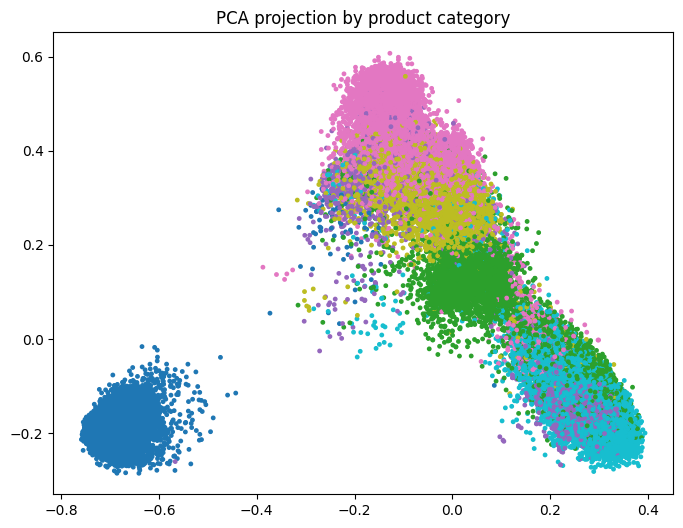

In [15]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Your embeddings should be a list of lists/arrays (each 1000-d vector)
embeddings = df_resampled["review_embedding"].tolist()

# Reduce to 2D
pca = PCA(n_components=2, random_state=42)
emb_2d = pca.fit_transform(embeddings)

# Convert product categories to numeric codes for coloring
category_codes = df_resampled["predicted_product_category"].astype("category").cat.codes

plt.figure(figsize=(8,6))
plt.scatter(emb_2d[:,0], emb_2d[:,1], c=category_codes, cmap="tab10", s=6)
plt.title("PCA projection by product category")
plt.show()